In [4]:
import json
import shutil
from pathlib import Path
import glob
import os
import random

def load_coco_data(json_path):
    """Load COCO annotation file."""
    with open(json_path, 'r') as f:
        return json.load(f)

def process_all_files(tiff_dir='./results/tiff', json_dir='./results/json',
                     output_dir='plants_coco', train_ratio=0.8):
    """
    Split TIFF and JSON file pairs into train and test directories.
    """
    # Create directory structure
    output_path = Path(output_dir)
    train_dir = output_path / 'images' / 'train'
    test_dir = output_path / 'images' / 'test'
    
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    
    # Find all TIFF files (both .tif and .tiff extensions)
    tiff_files = sorted(glob.glob(os.path.join(tiff_dir, '*.tif')) + 
                       glob.glob(os.path.join(tiff_dir, '*.tiff')))
    print(f"Found {len(tiff_files)} TIFF files in {tiff_dir}")
    
    if not tiff_files:
        print(f"No TIFF files found in {tiff_dir}")
        print(f"Please check that the directory exists and contains .tif or .tiff files")
        return
    
    # Find matching JSON files
    file_pairs = []
    for tiff_path in tiff_files:
        base_name = Path(tiff_path).stem
        json_path = os.path.join(json_dir, f"{base_name}.json")
        
        if os.path.exists(json_path):
            file_pairs.append((tiff_path, json_path, base_name))
        else:
            print(f"Warning: JSON file not found for {base_name}, skipping...")
    
    print(f"Found {len(file_pairs)} matching TIFF/JSON pairs")
    
    # Randomly shuffle and split files
    random.shuffle(file_pairs)
    train_count = int(len(file_pairs) * train_ratio)
    train_pairs = file_pairs[:train_count]
    test_pairs = file_pairs[train_count:]
    
    print(f"\nSplitting into:")
    print(f"  Train: {len(train_pairs)} files")
    print(f"  Test: {len(test_pairs)} files")
    
    # Process train files
    print("\nCopying train files...")
    train_images = []
    train_annotations = []
    categories = []
    
    for idx, (tiff_path, json_path, base_name) in enumerate(train_pairs):
        # Copy TIFF file
        tiff_filename = Path(tiff_path).name
        shutil.copy2(tiff_path, train_dir / tiff_filename)
        
        # Load and process JSON
        coco_data = load_coco_data(json_path)
        
        # Get categories from first file
        if not categories and 'categories' in coco_data:
            categories = coco_data['categories']
        
        # Add image info
        if 'images' in coco_data:
            for img_info in coco_data['images']:
                img_info['id'] = len(train_images) + 1
                img_info['file_name'] = tiff_filename
                train_images.append(img_info)
        
        # Add annotations
        if 'annotations' in coco_data:
            for ann in coco_data['annotations']:
                ann['id'] = len(train_annotations) + 1
                ann['image_id'] = len(train_images)  # Reference the last added image
                train_annotations.append(ann)
        
        print(f"  Processed {idx + 1}/{len(train_pairs)}: {base_name}")
    
    # Process test files
    print("\nCopying test files...")
    test_images = []
    test_annotations = []
    
    for idx, (tiff_path, json_path, base_name) in enumerate(test_pairs):
        # Copy TIFF file
        tiff_filename = Path(tiff_path).name
        shutil.copy2(tiff_path, test_dir / tiff_filename)
        
        # Load and process JSON
        coco_data = load_coco_data(json_path)
        
        # Add image info
        if 'images' in coco_data:
            for img_info in coco_data['images']:
                img_info['id'] = len(test_images) + 1
                img_info['file_name'] = tiff_filename
                test_images.append(img_info)
        
        # Add annotations
        if 'annotations' in coco_data:
            for ann in coco_data['annotations']:
                ann['id'] = len(test_annotations) + 1
                ann['image_id'] = len(test_images)  # Reference the last added image
                test_annotations.append(ann)
        
        print(f"  Processed {idx + 1}/{len(test_pairs)}: {base_name}")
    
    # Create combined COCO annotation files
    train_coco = {
        'images': train_images,
        'annotations': train_annotations,
        'categories': categories
    }
    
    test_coco = {
        'images': test_images,
        'annotations': test_annotations,
        'categories': categories
    }
    
    # Save annotation files inside train and test directories
    train_json_path = train_dir / 'train_annotations.json'
    test_json_path = test_dir / 'test_annotations.json'
    
    with open(train_json_path, 'w') as f:
        json.dump(train_coco, f, indent=2)
    
    with open(test_json_path, 'w') as f:
        json.dump(test_coco, f, indent=2)
    
    # Print final summary
    print(f"\n{'='*60}")
    print("PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"\nTrain set:")
    print(f"  Files: {len(train_pairs)}")
    print(f"  Images: {len(train_images)}")
    print(f"  Annotations: {len(train_annotations)}")
    print(f"  Directory: {train_dir}")
    print(f"  Annotation file: {train_json_path}")
    
    print(f"\nTest set:")
    print(f"  Files: {len(test_pairs)}")
    print(f"  Images: {len(test_images)}")
    print(f"  Annotations: {len(test_annotations)}")
    print(f"  Directory: {test_dir}")
    print(f"  Annotation file: {test_json_path}")
    
    print(f"\nDirectory structure:")
    print(f"  {output_dir}/")
    print(f"    └── images/")
    print(f"        ├── train/")
    print(f"        │   ├── train_annotations.json")
    print(f"        │   └── [TIFF files]")
    print(f"        └── test/")
    print(f"            ├── test_annotations.json")
    print(f"            └── [TIFF files]")

# Usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    
    process_all_files(
        tiff_dir='./data/images',
        json_dir='./data/coco',
        output_dir='./result/plants_coco_fullsize_33tiff',
        train_ratio=0.8
    )


Found 33 TIFF files in ./data/images
Found 33 matching TIFF/JSON pairs

Splitting into:
  Train: 26 files
  Test: 7 files

Copying train files...
  Processed 1/26: 20260212_092402_petiole15_00100
  Processed 2/26: 20211222_104840_petiole_test2_00100
  Processed 3/26: 20211222_113313_petiole3_00200
  Processed 4/26: 20211222_125057_petiole4_00200
  Processed 5/26: 20260212_085927_petiole13__00100
  Processed 6/26: 20211222_113313_petiole3_00300
  Processed 7/26: 20260211_125444_petiole1_00100
  Processed 8/26: 20211222_125057_petiole4_00100
  Processed 9/26: 20211222_113313_petiole3_00100
  Processed 10/26: 20211222_113313_petiole3_00500
  Processed 11/26: 20211222_125057_petiole4_00500
  Processed 12/26: 20260211_150303_petiole6_00100
  Processed 13/26: 20211222_104840_petiole_test2_00500
  Processed 14/26: 20260212_133951_petiole30_00100
  Processed 15/26: 20260211_162350_petiole10_00100
  Processed 16/26: 20211222_104840_petiole_test2_00200
  Processed 17/26: 20260211_175721_petiole1

In [1]:
import json
from pathlib import Path
from collections import defaultdict

def validate_polygon(segmentation):
    """
    Validate a polygon segmentation.
    Returns (is_valid, reason) tuple.
    """
    # Check if it's a list
    if not isinstance(segmentation, list):
        return False, "Not a list"
    
    # Check minimum length (need at least 3 points = 6 coordinates)
    if len(segmentation) < 6:
        return False, f"Too few coordinates ({len(segmentation)}, need at least 6)"
    
    # Check if even number of coordinates
    if len(segmentation) % 2 != 0:
        return False, f"Odd number of coordinates ({len(segmentation)})"
    
    # Check if all values are numeric
    try:
        coords = [float(x) for x in segmentation]
    except (ValueError, TypeError) as e:
        return False, f"Non-numeric values: {e}"
    
    # Check for NaN or Inf values
    if any(not (-1e10 < x < 1e10) for x in coords):
        return False, "Contains NaN or Inf values"
    
    # Convert to coordinate pairs
    num_points = len(coords) // 2
    points = [(coords[i*2], coords[i*2+1]) for i in range(num_points)]
    
    # Check for duplicate consecutive points (degenerate polygon)
    duplicate_count = 0
    for i in range(len(points) - 1):
        if points[i] == points[i+1]:
            duplicate_count += 1
    
    if duplicate_count > 0:
        return False, f"Contains {duplicate_count} duplicate consecutive points"
    
    # Check if all points are the same (degenerate)
    if len(set(points)) == 1:
        return False, "All points are identical"
    
    # Check if points are collinear (all on a line)
    if len(set(points)) == 2:
        return False, "Only 2 unique points (degenerate line)"
    
    return True, "Valid"

def check_annotation_file(json_path, verbose=False):
    """
    Check a COCO annotation file for invalid polygons.
    
    Args:
        json_path: Path to the annotation JSON file
        verbose: If True, print details of each invalid polygon
    
    Returns:
        Dictionary with validation results
    """
    print(f"\n{'='*60}")
    print(f"Checking: {json_path}")
    print(f"{'='*60}")
    
    # Load JSON file
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"ERROR: File not found: {json_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"ERROR: Invalid JSON file: {e}")
        return None
    
    # Extract data
    images = data.get('images', [])
    annotations = data.get('annotations', [])
    categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}
    
    print(f"\nFile Statistics:")
    print(f"  Total images: {len(images)}")
    print(f"  Total annotations: {len(annotations)}")
    print(f"  Categories: {len(categories)}")
    
    # Validation results
    results = {
        'total_annotations': len(annotations),
        'total_segmentations': 0,
        'valid_segmentations': 0,
        'invalid_segmentations': 0,
        'invalid_by_reason': defaultdict(int),
        'invalid_by_category': defaultdict(int),
        'invalid_by_image': defaultdict(list),
        'annotations_with_issues': []
    }
    
    # Check each annotation
    print(f"\nValidating polygons...")
    
    for ann_idx, ann in enumerate(annotations):
        ann_id = ann.get('id', ann_idx)
        image_id = ann.get('image_id', 'unknown')
        category_id = ann.get('category_id', 'unknown')
        category_name = categories.get(category_id, f"Unknown({category_id})")
        
        # Check if segmentation exists
        if 'segmentation' not in ann:
            results['invalid_segmentations'] += 1
            results['invalid_by_reason']['Missing segmentation field'] += 1
            results['annotations_with_issues'].append({
                'ann_id': ann_id,
                'image_id': image_id,
                'category': category_name,
                'reason': 'Missing segmentation field'
            })
            continue
        
        segmentations = ann['segmentation']
        
        # Check if segmentation is a list
        if not isinstance(segmentations, list):
            results['invalid_segmentations'] += 1
            results['invalid_by_reason']['Segmentation not a list'] += 1
            results['annotations_with_issues'].append({
                'ann_id': ann_id,
                'image_id': image_id,
                'category': category_name,
                'reason': 'Segmentation not a list'
            })
            continue
        
        # Check each polygon in the segmentation
        ann_has_issue = False
        for seg_idx, seg in enumerate(segmentations):
            results['total_segmentations'] += 1
            
            is_valid, reason = validate_polygon(seg)
            
            if is_valid:
                results['valid_segmentations'] += 1
            else:
                results['invalid_segmentations'] += 1
                results['invalid_by_reason'][reason] += 1
                results['invalid_by_category'][category_name] += 1
                results['invalid_by_image'][image_id].append({
                    'ann_id': ann_id,
                    'seg_idx': seg_idx,
                    'category': category_name,
                    'reason': reason
                })
                
                if not ann_has_issue:
                    ann_has_issue = True
                    results['annotations_with_issues'].append({
                        'ann_id': ann_id,
                        'image_id': image_id,
                        'category': category_name,
                        'reason': reason,
                        'seg_index': seg_idx
                    })
                
                if verbose:
                    print(f"\n  INVALID: Ann ID {ann_id}, Image {image_id}, "
                          f"Category {category_name}, Seg {seg_idx}")
                    print(f"    Reason: {reason}")
                    print(f"    Polygon: {seg[:20]}..." if len(seg) > 20 else f"    Polygon: {seg}")
    
    # Print summary
    print(f"\n{'='*60}")
    print("VALIDATION SUMMARY")
    print(f"{'='*60}")
    print(f"\nTotal Statistics:")
    print(f"  Annotations: {results['total_annotations']}")
    print(f"  Segmentation polygons: {results['total_segmentations']}")
    print(f"  Valid polygons: {results['valid_segmentations']} "
          f"({100*results['valid_segmentations']/max(1, results['total_segmentations']):.1f}%)")
    print(f"  Invalid polygons: {results['invalid_segmentations']} "
          f"({100*results['invalid_segmentations']/max(1, results['total_segmentations']):.1f}%)")
    print(f"  Annotations with issues: {len(results['annotations_with_issues'])}")
    
    if results['invalid_segmentations'] > 0:
        print(f"\nInvalid Polygons by Reason:")
        for reason, count in sorted(results['invalid_by_reason'].items(), 
                                    key=lambda x: x[1], reverse=True):
            print(f"  {reason}: {count}")
        
        print(f"\nInvalid Polygons by Category:")
        for category, count in sorted(results['invalid_by_category'].items(), 
                                      key=lambda x: x[1], reverse=True):
            print(f"  {category}: {count}")
        
        print(f"\nImages with Invalid Polygons: {len(results['invalid_by_image'])}")
        if len(results['invalid_by_image']) <= 10:
            for img_id, issues in results['invalid_by_image'].items():
                print(f"  Image {img_id}: {len(issues)} invalid polygon(s)")
        else:
            print(f"  (Too many to display, showing top 10)")
            sorted_images = sorted(results['invalid_by_image'].items(), 
                                  key=lambda x: len(x[1]), reverse=True)[:10]
            for img_id, issues in sorted_images:
                print(f"  Image {img_id}: {len(issues)} invalid polygon(s)")
    
    return results

def check_dataset(data_dir, verbose=False, save_report=True):
    """
    Check both train and test annotation files in a dataset.
    
    Args:
        data_dir: Root directory (e.g., './result/plants_coco_fullsize_33tiff')
        verbose: If True, print details of each invalid polygon
        save_report: If True, save a detailed report to a text file
    """
    print("\n" + "#"*60)
    print("# DATASET VALIDATION CHECK")
    print("#"*60)
    
    data_path = Path(data_dir)
    
    # Check train set
    train_json = data_path / 'images' / 'train' / 'train_annotations.json'
    train_results = check_annotation_file(train_json, verbose=verbose)
    
    # Check test set
    test_json = data_path / 'images' / 'test' / 'test_annotations.json'
    test_results = check_annotation_file(test_json, verbose=verbose)
    
    # Combined summary
    if train_results and test_results:
        print(f"\n{'='*60}")
        print("COMBINED SUMMARY")
        print(f"{'='*60}")
        
        total_annotations = train_results['total_annotations'] + test_results['total_annotations']
        total_segs = train_results['total_segmentations'] + test_results['total_segmentations']
        valid_segs = train_results['valid_segmentations'] + test_results['valid_segmentations']
        invalid_segs = train_results['invalid_segmentations'] + test_results['invalid_segmentations']
        
        print(f"\nOverall Statistics:")
        print(f"  Total annotations: {total_annotations}")
        print(f"  Total segmentation polygons: {total_segs}")
        print(f"  Valid polygons: {valid_segs} ({100*valid_segs/max(1, total_segs):.1f}%)")
        print(f"  Invalid polygons: {invalid_segs} ({100*invalid_segs/max(1, total_segs):.1f}%)")
        
        if invalid_segs > 0:
            print(f"\n  ⚠️  WARNING: Found {invalid_segs} invalid polygon(s) in the dataset!")
            print(f"  These should be fixed before training.")
        else:
            print(f"\n  ✓ All polygons are valid!")
        
        # Save detailed report if requested
        if save_report:
            report_path = data_path / 'validation_report.txt'
            with open(report_path, 'w') as f:
                f.write("DATASET VALIDATION REPORT\n")
                f.write("="*60 + "\n\n")
                
                f.write("TRAIN SET\n")
                f.write("-"*60 + "\n")
                f.write(f"Total annotations: {train_results['total_annotations']}\n")
                f.write(f"Total polygons: {train_results['total_segmentations']}\n")
                f.write(f"Valid polygons: {train_results['valid_segmentations']}\n")
                f.write(f"Invalid polygons: {train_results['invalid_segmentations']}\n\n")
                
                if train_results['invalid_segmentations'] > 0:
                    f.write("Invalid polygons by reason:\n")
                    for reason, count in train_results['invalid_by_reason'].items():
                        f.write(f"  {reason}: {count}\n")
                    f.write("\n")
                
                f.write("\nTEST SET\n")
                f.write("-"*60 + "\n")
                f.write(f"Total annotations: {test_results['total_annotations']}\n")
                f.write(f"Total polygons: {test_results['total_segmentations']}\n")
                f.write(f"Valid polygons: {test_results['valid_segmentations']}\n")
                f.write(f"Invalid polygons: {test_results['invalid_segmentations']}\n\n")
                
                if test_results['invalid_segmentations'] > 0:
                    f.write("Invalid polygons by reason:\n")
                    for reason, count in test_results['invalid_by_reason'].items():
                        f.write(f"  {reason}: {count}\n")
                    f.write("\n")
                
                f.write("\nDETAILED ISSUES\n")
                f.write("="*60 + "\n\n")
                
                f.write("Train set issues:\n")
                for issue in train_results['annotations_with_issues'][:50]:  # Limit to first 50
                    f.write(f"  Ann {issue['ann_id']}, Image {issue['image_id']}, "
                           f"Category {issue['category']}: {issue['reason']}\n")
                
                f.write("\nTest set issues:\n")
                for issue in test_results['annotations_with_issues'][:50]:  # Limit to first 50
                    f.write(f"  Ann {issue['ann_id']}, Image {issue['image_id']}, "
                           f"Category {issue['category']}: {issue['reason']}\n")
            
            print(f"\nDetailed report saved to: {report_path}")
    
    return train_results, test_results

# Usage
if __name__ == "__main__":
    # Check your dataset
    check_dataset(
        data_dir='./result/plants_coco_fullsize_33tiff',
        verbose=False,  # Set to True to see details of each invalid polygon
        save_report=True  # Saves a detailed report to validation_report.txt
    )


############################################################
# DATASET VALIDATION CHECK
############################################################

Checking: result/plants_coco_fullsize_33tiff/images/train/train_annotations.json

File Statistics:
  Total images: 26
  Total annotations: 40985
  Categories: 6

Validating polygons...

VALIDATION SUMMARY

Total Statistics:
  Annotations: 40985
  Segmentation polygons: 40985
  Valid polygons: 40982 (100.0%)
  Invalid polygons: 3 (0.0%)
  Annotations with issues: 3

Invalid Polygons by Reason:
  Too few coordinates (4, need at least 6): 3

Invalid Polygons by Category:
  Water-based Pith cells: 2
  Cortex: 1

Images with Invalid Polygons: 2
  Image 10: 1 invalid polygon(s)
  Image 26: 2 invalid polygon(s)

Checking: result/plants_coco_fullsize_33tiff/images/test/test_annotations.json

File Statistics:
  Total images: 7
  Total annotations: 11029
  Categories: 6

Validating polygons...

VALIDATION SUMMARY

Total Statistics:
  Annotations: 

In [2]:
import json
from pathlib import Path
from collections import defaultdict

def validate_polygon(segmentation):
    """
    Validate a polygon segmentation.
    Returns (is_valid, reason) tuple.
    """
    # Check if it's a list
    if not isinstance(segmentation, list):
        return False, "Not a list"
    
    # Check minimum length (need at least 3 points = 6 coordinates)
    if len(segmentation) < 6:
        return False, f"Too few coordinates ({len(segmentation)}, need at least 6)"
    
    # Check if even number of coordinates
    if len(segmentation) % 2 != 0:
        return False, f"Odd number of coordinates ({len(segmentation)})"
    
    # Check if all values are numeric
    try:
        coords = [float(x) for x in segmentation]
    except (ValueError, TypeError) as e:
        return False, f"Non-numeric values: {e}"
    
    # Check for NaN or Inf values
    if any(not (-1e10 < x < 1e10) for x in coords):
        return False, "Contains NaN or Inf values"
    
    # Convert to coordinate pairs
    num_points = len(coords) // 2
    points = [(coords[i*2], coords[i*2+1]) for i in range(num_points)]
    
    # Check for duplicate consecutive points
    duplicate_count = 0
    for i in range(len(points) - 1):
        if points[i] == points[i+1]:
            duplicate_count += 1
    
    if duplicate_count > 0:
        return False, f"Contains {duplicate_count} duplicate consecutive points"
    
    # Check if all points are the same
    if len(set(points)) == 1:
        return False, "All points are identical"
    
    # Check if points are collinear
    if len(set(points)) == 2:
        return False, "Only 2 unique points (degenerate line)"
    
    return True, "Valid"

def clean_annotation_file(json_path, output_path=None):
    """
    Remove annotations with invalid polygons from a COCO annotation file.
    Saves to a new file, keeping the original intact.
    
    Args:
        json_path: Path to the original annotation JSON file
        output_path: Path for the cleaned file (if None, uses _cleaned suffix)
    
    Returns:
        Dictionary with cleaning results
    """
    print(f"\n{'='*60}")
    print(f"Cleaning: {json_path}")
    print(f"{'='*60}")
    
    # Load JSON file
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"ERROR: File not found: {json_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"ERROR: Invalid JSON file: {e}")
        return None
    
    # Determine output path
    if output_path is None:
        json_path_obj = Path(json_path)
        output_path = json_path_obj.parent / f"{json_path_obj.stem}_cleaned{json_path_obj.suffix}"
    
    # Extract data
    images = data.get('images', [])
    annotations = data.get('annotations', [])
    categories = data.get('categories', [])
    
    print(f"\nOriginal Statistics:")
    print(f"  Total images: {len(images)}")
    print(f"  Total annotations: {len(annotations)}")
    
    # Results tracking
    results = {
        'original_annotations': len(annotations),
        'removed_annotations': 0,
        'kept_annotations': 0,
        'polygons_removed_from_kept_annotations': 0,
        'removed_by_reason': defaultdict(int),
        'removed_by_category': defaultdict(int),
        'removed_details': []
    }
    
    category_names = {cat['id']: cat['name'] for cat in categories}
    
    # Filter annotations
    cleaned_annotations = []
    
    for ann in annotations:
        ann_id = ann.get('id')
        image_id = ann.get('image_id')
        category_id = ann.get('category_id')
        category_name = category_names.get(category_id, f"Unknown({category_id})")
        
        # Check if segmentation exists
        if 'segmentation' not in ann:
            results['removed_annotations'] += 1
            results['removed_by_reason']['Missing segmentation field'] += 1
            results['removed_by_category'][category_name] += 1
            results['removed_details'].append({
                'ann_id': ann_id,
                'image_id': image_id,
                'category': category_name,
                'reason': 'Missing segmentation field'
            })
            continue
        
        # Validate each polygon in segmentation
        segmentations = ann['segmentation']
        
        if not isinstance(segmentations, list):
            results['removed_annotations'] += 1
            results['removed_by_reason']['Segmentation not a list'] += 1
            results['removed_by_category'][category_name] += 1
            results['removed_details'].append({
                'ann_id': ann_id,
                'image_id': image_id,
                'category': category_name,
                'reason': 'Segmentation not a list'
            })
            continue
        
        # Filter valid polygons within this annotation
        valid_segs = []
        has_invalid = False
        invalid_reason = None
        invalid_count = 0
        
        for seg in segmentations:
            is_valid, reason = validate_polygon(seg)
            if is_valid:
                valid_segs.append(seg)
            else:
                has_invalid = True
                invalid_reason = reason
                invalid_count += 1
        
        # If annotation has at least one valid polygon, keep it with only valid polygons
        if valid_segs:
            # Create a copy of the annotation
            cleaned_ann = ann.copy()
            cleaned_ann['segmentation'] = valid_segs
            cleaned_annotations.append(cleaned_ann)
            results['kept_annotations'] += 1
            
            # Report if we removed some polygons from this annotation
            if has_invalid:
                results['polygons_removed_from_kept_annotations'] += invalid_count
                print(f"  Cleaned ann {ann_id}: kept {len(valid_segs)}/{len(segmentations)} polygons")
        else:
            # Remove entire annotation if no valid polygons
            results['removed_annotations'] += 1
            results['removed_by_reason'][invalid_reason] += 1
            results['removed_by_category'][category_name] += 1
            results['removed_details'].append({
                'ann_id': ann_id,
                'image_id': image_id,
                'category': category_name,
                'reason': invalid_reason
            })
    
    # Create cleaned data
    cleaned_data = {
        'images': images,
        'annotations': cleaned_annotations,
        'categories': categories
    }
    
    # Save cleaned file
    with open(output_path, 'w') as f:
        json.dump(cleaned_data, f, indent=2)
    
    # Print summary
    print(f"\n{'='*60}")
    print("CLEANING SUMMARY")
    print(f"{'='*60}")
    print(f"\nAnnotations:")
    print(f"  Original: {results['original_annotations']}")
    print(f"  Kept: {results['kept_annotations']}")
    print(f"  Removed completely: {results['removed_annotations']}")
    if results['polygons_removed_from_kept_annotations'] > 0:
        print(f"  Polygons removed from kept annotations: {results['polygons_removed_from_kept_annotations']}")
    
    if results['removed_annotations'] > 0:
        print(f"\nRemoved Annotations by Reason:")
        for reason, count in sorted(results['removed_by_reason'].items(), 
                                    key=lambda x: x[1], reverse=True):
            print(f"  {reason}: {count}")
        
        print(f"\nRemoved Annotations by Category:")
        for category, count in sorted(results['removed_by_category'].items(), 
                                      key=lambda x: x[1], reverse=True):
            print(f"  {category}: {count}")
        
        print(f"\nRemoved Annotation Details:")
        for detail in results['removed_details']:
            print(f"  Ann {detail['ann_id']}, Image {detail['image_id']}, "
                  f"Category {detail['category']}: {detail['reason']}")
    
    print(f"\n✓ Original file preserved: {json_path}")
    print(f"✓ Cleaned file saved: {output_path}")
    
    return results

def clean_dataset(data_dir):
    """
    Clean both train and test annotation files in a dataset.
    Creates new _cleaned.json files, keeping originals intact.
    
    Args:
        data_dir: Root directory (e.g., './result/plants_coco_fullsize_33tiff')
    """
    print("\n" + "#"*60)
    print("# DATASET CLEANING")
    print("#"*60)
    
    data_path = Path(data_dir)
    
    # Clean train set
    train_json = data_path / 'images' / 'train' / 'train_annotations.json'
    train_output = data_path / 'images' / 'train' / 'train_annotations_cleaned.json'
    train_results = clean_annotation_file(train_json, train_output)
    
    # Clean test set
    test_json = data_path / 'images' / 'test' / 'test_annotations.json'
    test_output = data_path / 'images' / 'test' / 'test_annotations_cleaned.json'
    test_results = clean_annotation_file(test_json, test_output)
    
    # Combined summary
    if train_results and test_results:
        print(f"\n{'='*60}")
        print("COMBINED CLEANING SUMMARY")
        print(f"{'='*60}")
        
        total_original = train_results['original_annotations'] + test_results['original_annotations']
        total_kept = train_results['kept_annotations'] + test_results['kept_annotations']
        total_removed = train_results['removed_annotations'] + test_results['removed_annotations']
        total_polygons_removed = (train_results['polygons_removed_from_kept_annotations'] + 
                                 test_results['polygons_removed_from_kept_annotations'])
        
        print(f"\nOverall Results:")
        print(f"  Original annotations: {total_original}")
        print(f"  Kept annotations: {total_kept}")
        print(f"  Removed annotations: {total_removed}")
        print(f"  Polygons removed from kept annotations: {total_polygons_removed}")
        print(f"  Removal rate: {100*total_removed/max(1, total_original):.2f}%")
        
        print(f"\nOutput Files:")
        print(f"  Train: {train_output}")
        print(f"  Test: {test_output}")
        
        if total_removed > 0 or total_polygons_removed > 0:
            print(f"\n  ✓ Successfully cleaned dataset!")
            print(f"    - Removed {total_removed} complete annotation(s)")
            print(f"    - Removed {total_polygons_removed} invalid polygon(s) from kept annotations")
        else:
            print(f"\n  ✓ No invalid annotations found!")
        
        print(f"\n  📁 Original files preserved:")
        print(f"     - {train_json}")
        print(f"     - {test_json}")
    
    return train_results, test_results

# Usage
if __name__ == "__main__":
    # Clean the dataset (creates new _cleaned.json files)
    clean_dataset(
        data_dir='./result/plants_coco_fullsize_33tiff'
    )



############################################################
# DATASET CLEANING
############################################################

Cleaning: result/plants_coco_fullsize_33tiff/images/train/train_annotations.json

Original Statistics:
  Total images: 26
  Total annotations: 40985

CLEANING SUMMARY

Annotations:
  Original: 40985
  Kept: 40982
  Removed completely: 3

Removed Annotations by Reason:
  Too few coordinates (4, need at least 6): 3

Removed Annotations by Category:
  Water-based Pith cells: 2
  Cortex: 1

Removed Annotation Details:
  Ann 14396, Image 10, Category Water-based Pith cells: Too few coordinates (4, need at least 6)
  Ann 40899, Image 26, Category Cortex: Too few coordinates (4, need at least 6)
  Ann 40935, Image 26, Category Water-based Pith cells: Too few coordinates (4, need at least 6)

✓ Original file preserved: result/plants_coco_fullsize_33tiff/images/train/train_annotations.json
✓ Cleaned file saved: result/plants_coco_fullsize_33tiff/images/t


VERIFYING COCO DATASET (RANDOM SAMPLING)

############################################################
# TRAIN SET VERIFICATION
############################################################

Loading TRAIN set from: result/plants_coco_fullsize_33tiff/images/train

Dataset Statistics:
  Total images: 26
  Total annotations: 40982

  Annotations per class:
    Cortex: 23364
    Phloem Fibers: 1153
    Phloem: 93
    Xylem vessels: 10786
    Air-based Pith cells: 877
    Water-based Pith cells: 4709

  Randomly selected 6 patches for visualization

Processing 20211222_125057_petiole4_00400.tiff...
  Found 2427 annotations

Processing 20211222_125057_petiole4_00200.tiff...
  Found 2214 annotations

Processing 20260212_092402_petiole15_00100.tiff...
  Found 283 annotations

Processing 20211222_113313_petiole3_00100.tiff...
  Found 1729 annotations

Processing 20211222_125057_petiole4_00100.tiff...
  Found 2151 annotations

Processing 20211222_094342_petiole_test_00300.tiff...
  Found 1753 an

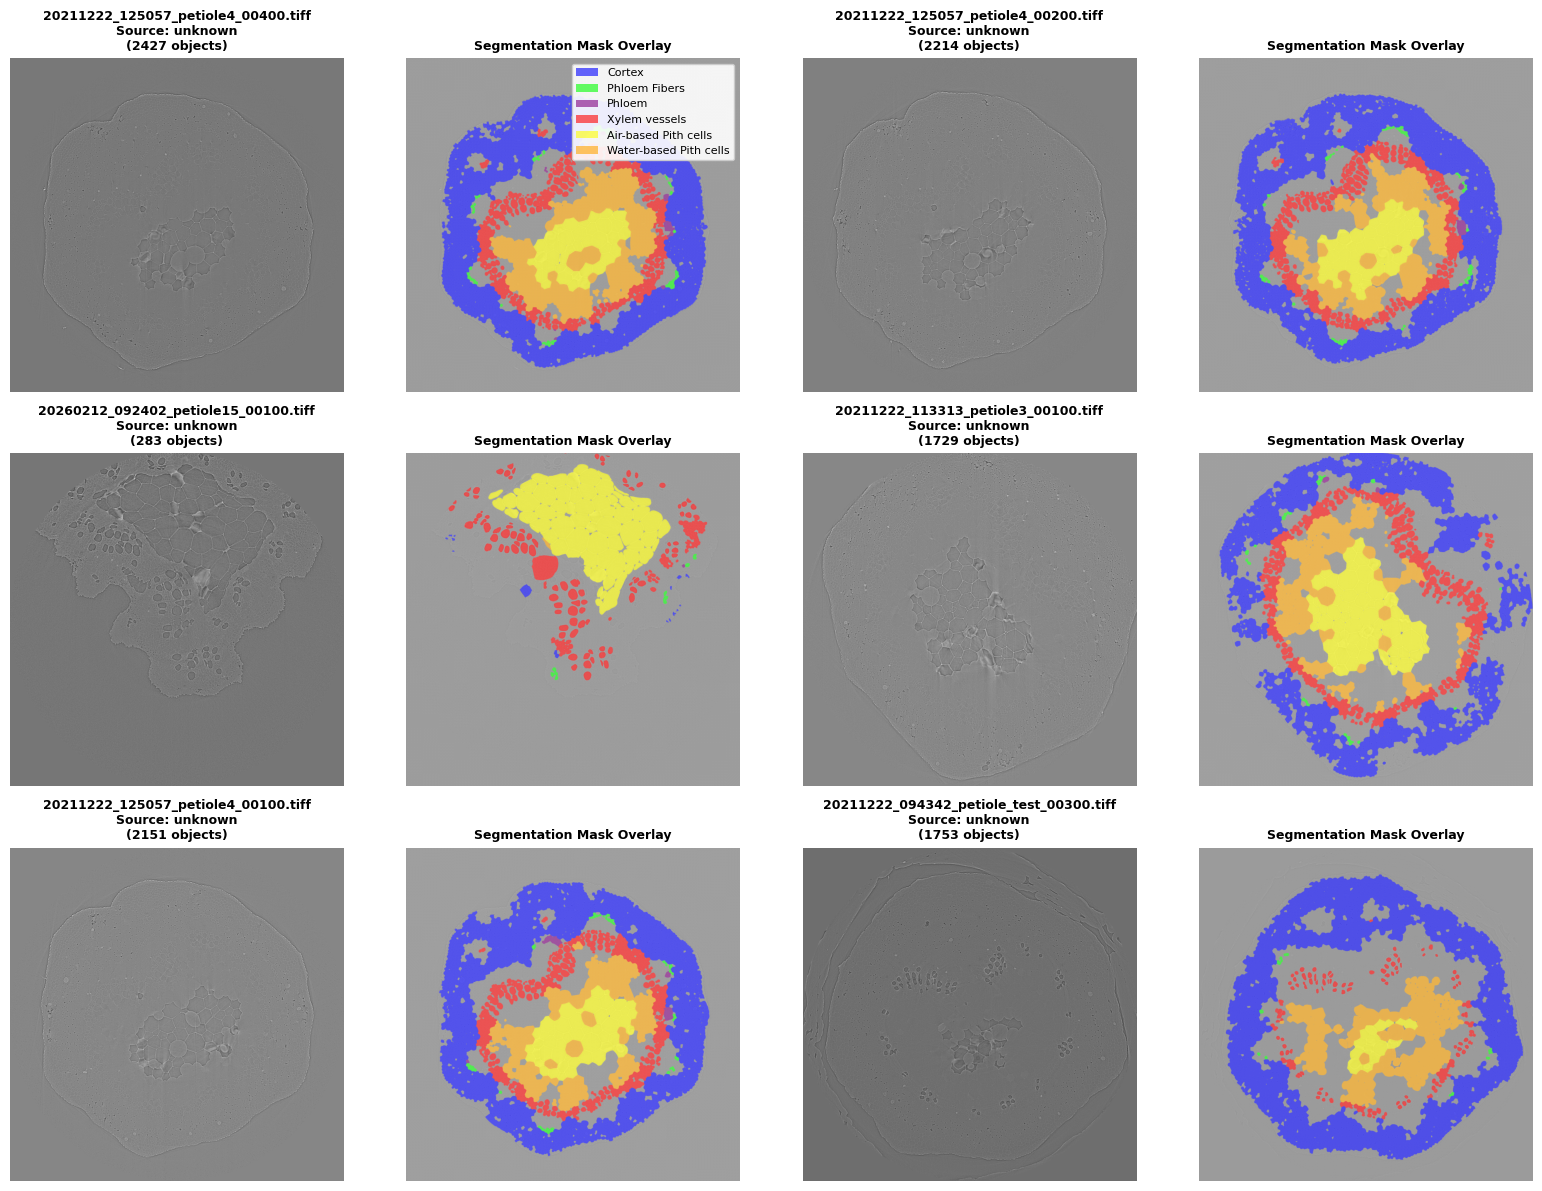


############################################################
# TEST SET VERIFICATION
############################################################

Loading TEST set from: result/plants_coco_fullsize_33tiff/images/test

Dataset Statistics:
  Total images: 7
  Total annotations: 11027

  Annotations per class:
    Cortex: 6025
    Phloem Fibers: 299
    Phloem: 11
    Xylem vessels: 2816
    Air-based Pith cells: 116
    Water-based Pith cells: 1760

  Randomly selected 6 patches for visualization

Processing 20211222_094342_petiole_test_00200.tiff...
  Found 1765 annotations

Processing 20211222_094342_petiole_test_00500.tiff...
  Found 1789 annotations

Processing 20211222_104840_petiole_test2_00300.tiff...
  Found 2256 annotations

Processing 20260212_174538_petiole36_00100.tiff...
  Found 1212 annotations

Processing 20260211_151737_petiole7_00100.tiff...
  Found 1160 annotations

Processing 20211222_104840_petiole_test2_00400.tiff...
  Found 2364 annotations

Visualization saved as 

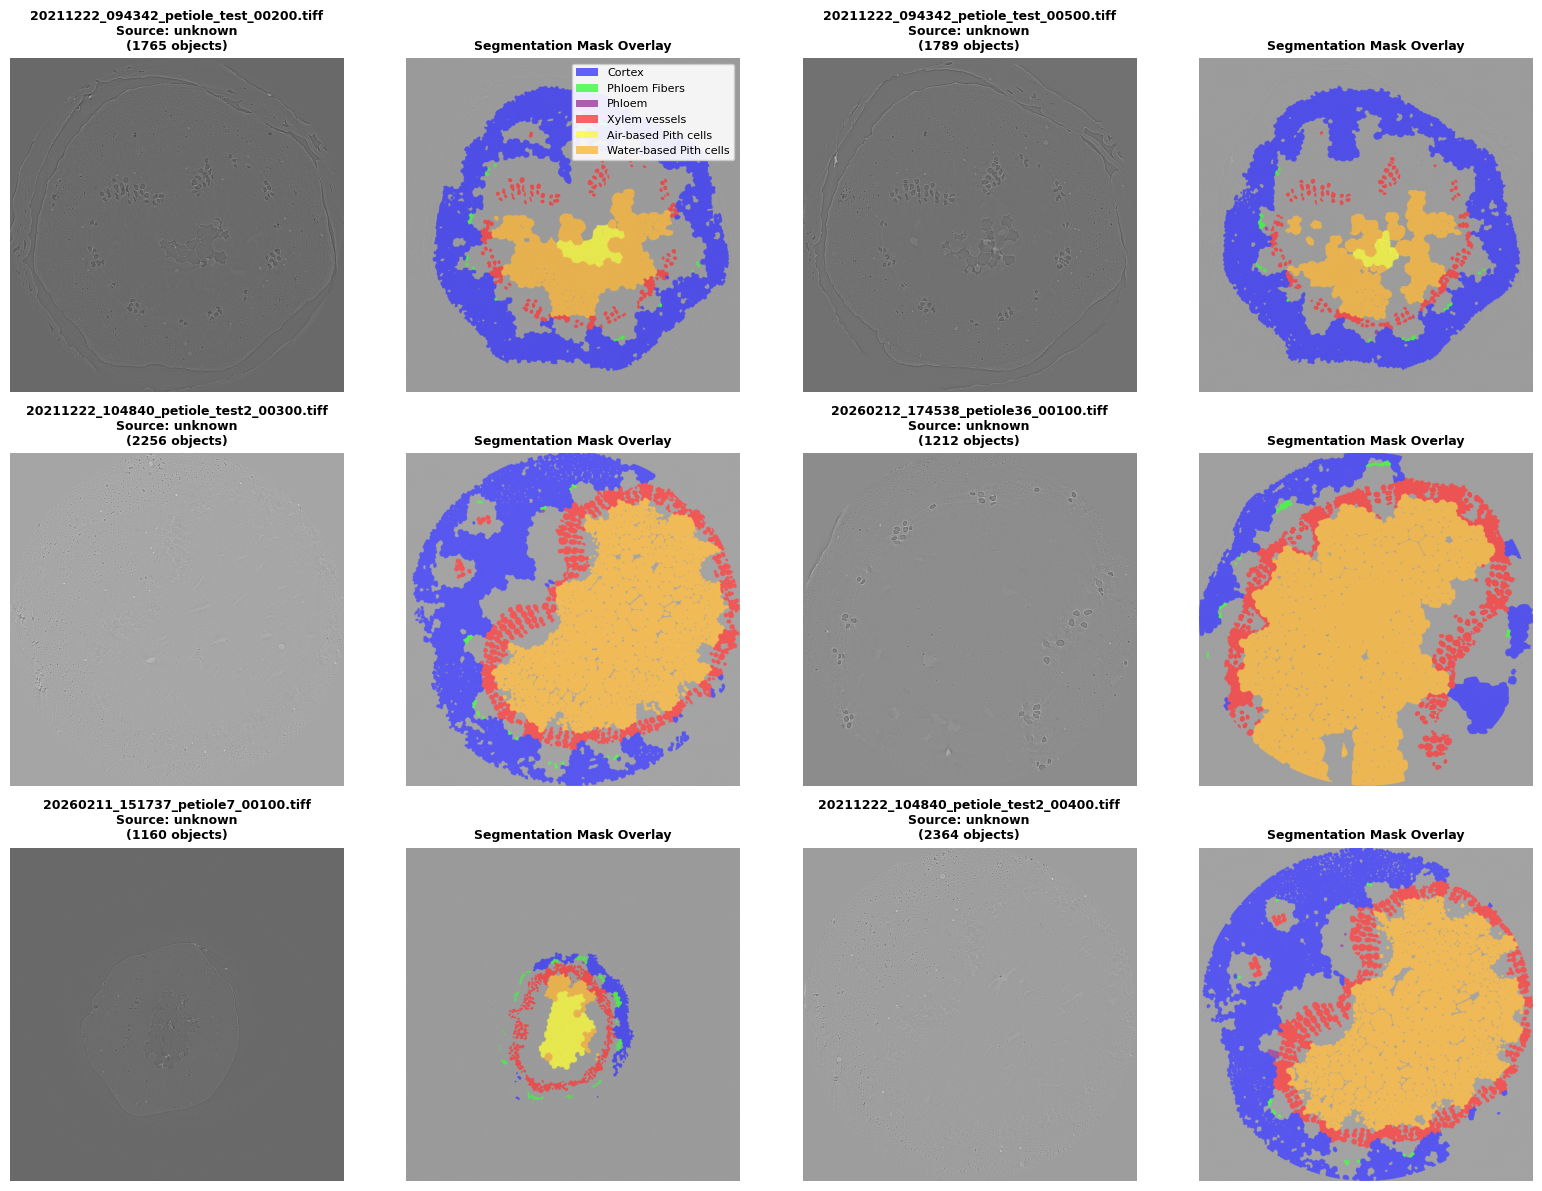


VERIFICATION COMPLETE!


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import random

def load_coco_data(json_path):
    """Load COCO annotation file."""
    with open(json_path, 'r') as f:
        return json.load(f)

def normalize_image(img_array):
    """Normalize image to 0-1 range for display."""
    img_min = img_array.min()
    img_max = img_array.max()
    if img_max > img_min:
        return (img_array - img_min) / (img_max - img_min)
    return img_array

def create_segmentation_mask(segmentation, img_shape, value):
    """Create a mask from segmentation polygon."""
    mask = Image.new('L', (img_shape[1], img_shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    
    coords = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
    draw.polygon(coords, fill=value)
    
    return np.array(mask)

def visualize_random_patches(data_dir, split='train', num_samples=6, seed=None):
    """
    Randomly select and visualize patches with their mask overlays.
    
    Args:
        data_dir: Root directory (e.g., 'plants_coco_640')
        split: 'train' or 'test'
        num_samples: Number of random patches to visualize
        seed: Random seed for reproducibility
    """
    if seed is not None:
        random.seed(seed)
    
    # Define paths
    data_path = Path(data_dir) / 'images' / split
    json_path = data_path / f'{split}_annotations_cleaned.json'
    
    # Check if files exist
    if not data_path.exists():
        print(f"Error: Directory not found: {data_path}")
        return
    
    if not json_path.exists():
        print(f"Error: Annotation file not found: {json_path}")
        return
    
    # Load annotations
    print(f"\n{'='*60}")
    print(f"Loading {split.upper()} set from: {data_path}")
    print(f"{'='*60}")
    
    coco_data = load_coco_data(json_path)
    
    # Extract info
    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Print statistics
    print(f"\nDataset Statistics:")
    print(f"  Total images: {len(images)}")
    print(f"  Total annotations: {len(annotations)}")
    
    # Count annotations per class
    class_counts = {}
    for ann in annotations:
        cat_id = ann['category_id']
        class_counts[cat_id] = class_counts.get(cat_id, 0) + 1
    
    print(f"\n  Annotations per class:")
    for cat_id in sorted(class_counts.keys(), key=str):
        print(f"    {categories[cat_id]}: {class_counts[cat_id]}")
    
    # Randomly select sample images
    num_samples = min(num_samples, len(images))
    sample_images = random.sample(images, num_samples)
    print(f"\n  Randomly selected {num_samples} patches for visualization")
    
    # Define colors for classes (RGB format: 0-255)
    class_colors = {
        0: [128, 128, 128],  # Gray - Background
        1: [0, 0, 255],      # Blue - Cortex
        2: [0, 255, 0],      # Green - Phloem Fibers
        3: [128, 0, 128],    # Purple - Phloem
        4: [255, 0, 0],      # Red - Xylem vessels
        5: [255, 255, 0],    # Yellow - Air-based Pith cells
        6: [255, 165, 0],    # Orange - Water-based Pith cells
    }
    
    # Convert RGB (0-255) to normalized RGB (0-1) with alpha for matplotlib
    class_colors_rgba = {}
    for cat_id, rgb in class_colors.items():
        class_colors_rgba[cat_id] = [rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0, 0.6]
    
    # Create visualization - 2 columns (original + overlay)
    rows = (num_samples + 1) // 2
    fig, axes = plt.subplots(rows, 4, figsize=(16, 4*rows))
    
    # Flatten axes for easier indexing
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_info in enumerate(sample_images):
        row = idx // 2
        col_offset = (idx % 2) * 2
        
        print(f"\nProcessing {img_info['file_name']}...")
        
        # Load image
        img_path = data_path / img_info['file_name']
        if not img_path.exists():
            print(f"  Warning: Image file not found: {img_path}")
            continue
            
        img = Image.open(img_path)
        img_array = np.array(img)
        img_normalized = normalize_image(img_array)
        
        # Get annotations for this image
        img_annotations = [ann for ann in annotations if ann['image_id'] == img_info['id']]
        print(f"  Found {len(img_annotations)} annotations")
        
        # Get source file info if available
        source_info = img_info.get('source_file', 'unknown')
        
        # 1. Original image
        axes[row, col_offset].imshow(img_normalized, cmap='gray')
        axes[row, col_offset].set_title(
            f"{img_info['file_name']}\nSource: {source_info}\n({len(img_annotations)} objects)", 
            fontsize=9, fontweight='bold'
        )
        axes[row, col_offset].axis('off')
        
        # 2. Mask overlay
        axes[row, col_offset + 1].imshow(img_normalized, cmap='gray', alpha=0.4)
        
        # Create colored overlay
        class_mask = np.zeros(img_array.shape, dtype=np.uint8)
        for ann in img_annotations:
            for segmentation in ann['segmentation']:
                category_id = ann['category_id']
                seg_mask = create_segmentation_mask(segmentation, img_array.shape, category_id)
                class_mask = np.maximum(class_mask, seg_mask)
        
        # Create RGBA overlay
        class_overlay_rgba = np.zeros((*img_array.shape, 4))
        for cat_id, color in class_colors_rgba.items():
            mask_region = class_mask == cat_id
            for c in range(4):
                class_overlay_rgba[:, :, c][mask_region] = color[c]
        
        axes[row, col_offset + 1].imshow(class_overlay_rgba)
        axes[row, col_offset + 1].set_title('Segmentation Mask Overlay', fontsize=9, fontweight='bold')
        axes[row, col_offset + 1].axis('off')
        
        # Add legend to first overlay (exclude background class 0)
        if idx == 0:
            legend_elements = [
                mpatches.Patch(
                    facecolor=[class_colors[i][0]/255.0, class_colors[i][1]/255.0, class_colors[i][2]/255.0], 
                    label=categories[i],
                    alpha=0.6
                ) 
                for i in sorted(categories.keys(), key=str) if i != 0  # Exclude background
            ]
            axes[row, col_offset + 1].legend(
                handles=legend_elements, 
                loc='upper right', 
                fontsize=8,
                framealpha=0.9
            )
    
    # Hide any unused subplots
    total_subplots = rows * 4
    used_subplots = num_samples * 2
    for i in range(used_subplots, total_subplots):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    output_path = f'{split}_random_samples_{num_samples}.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n{'='*60}")
    print(f"Visualization saved as '{output_path}'")
    print(f"{'='*60}")
    plt.show()

def verify_dataset_random(data_dir='plants_coco_640', num_samples_per_split=6, seed=42):
    """Randomly verify both train and test datasets."""
    
    print("\n" + "="*60)
    print("VERIFYING COCO DATASET (RANDOM SAMPLING)")
    print("="*60)
    
    # Verify train set
    print("\n" + "#"*60)
    print("# TRAIN SET VERIFICATION")
    print("#"*60)
    visualize_random_patches(data_dir, split='train', num_samples=num_samples_per_split, seed=seed)
    
    # Verify test set
    print("\n" + "#"*60)
    print("# TEST SET VERIFICATION")
    print("#"*60)
    visualize_random_patches(data_dir, split='test', num_samples=num_samples_per_split, seed=seed)
    
    print("\n" + "="*60)
    print("VERIFICATION COMPLETE!")
    print("="*60)

# Usage
if __name__ == "__main__":
    # Random seed for reproducibility (set to None for different samples each time)
    verify_dataset_random(
        data_dir='./result/plants_coco_fullsize_33tiff',
        num_samples_per_split=6,
        seed=42  # Change or set to None for different random samples
    )